# American Census

In [77]:
import numpy as np
import pandas as pd
import copy as copy
import seaborn as sns; sns.set()

from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit


import matplotlib.pyplot as plt

## Global config

In [78]:
# Data config
path_to_csv = "adult.csv"

## Load data

In [79]:
pandas_X_train = pd.read_csv("X_train.csv")
pandas_y_train = pd.read_csv("y_train.csv")

pandas_X_test = pd.read_csv("X_test.csv")

## Helpers

In [80]:
X_train = pandas_X_train.to_numpy(copy=True)
y_train = pandas_y_train.to_numpy(copy=True)

X_test = pandas_X_test.to_numpy(copy=True)

## Data exploration

### Question 1

In [81]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
unique_array = np.asarray((unique_elements, counts_elements))
print(unique_array)
print("From above we can derive that there are an unequal number of samples belonging to each class.")
print("Class distribution for salary <50.000$: ", np.round(counts_elements[0]/counts_elements.sum()*100, 2),"%")
print("Class distribution for salary >50.000$: ", np.round(counts_elements[1]/counts_elements.sum()*100, 2),"%")

[[    0     1]
 [12360  3920]]
From above we can derive that there are an unequal number of samples belonging to each class.
Class distribution for salary <50.000$:  75.92 %
Class distribution for salary >50.000$:  24.08 %


### Question 2

Based on training data: Men >$50k:  30.51 %, Women >$50k:  11.12 %.
Scaled to account for the difference between the number of men and women: Men >$50k:  15.13 %, Women >$50k:  11.12 %.
This means that the difference is quite insignificant, and thus this parameter isn't necessarily curcial.

Distribution of races:
[(' Amer-Indian-Eskimo', 146), (' Asian-Pac-Islander', 506), (' Black', 1537), (' Other', 138), (' White', 13953)]
The trained model will be highly biased towards the white race! Thus, race is also not quite a good paramter. The white race is found accross 85.71 % of the training data!


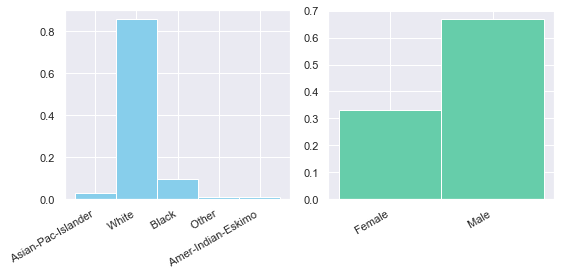

In [82]:
exteded_data = np.c_[X_train, y_train]

num_men = np.where((exteded_data[:, 9] == " Male"))[0].size
num_female = np.where((exteded_data[:, 9] == " Female"))[0].size
females_under_50 = np.where((exteded_data[:, 9] == " Female") & (exteded_data[:, 11] == 0))[0].size
females_over_50 = np.where((exteded_data[:, 9] == " Female") & (exteded_data[:, 11] == 1))[0].size
men_under_50 = np.where((exteded_data[:, 9] == " Male") & (exteded_data[:, 11] == 0))[0].size
men_over_50 = np.where((exteded_data[:, 9] == " Male") & (exteded_data[:, 11] == 1))[0].size

print("Based on training data: Men >$50k: ", round((men_over_50/num_men) * 100, 2) , "%, Women >$50k: ", round(females_over_50/num_female * 100, 2), "%.")
print("Scaled to account for the difference between the number of men and women: Men >$50k: ", round((men_over_50/num_men)/(num_men/num_female) * 100, 2) , "%, Women >$50k: ", round(females_over_50/num_female * 100, 2), "%.")
print("This means that the difference is quite insignificant, and thus this parameter isn't necessarily curcial.")

print()
print("Distribution of races:")
unique_races, counts_races = np.unique(X_train[:, 8], return_counts=True)
zipped = zip(unique_races, counts_races)
print(list(zipped))
print("The trained model will be highly biased towards the white race! Thus, race is also not quite a good paramter. The white race is found accross",
     round(counts_races[4] / X_train.shape[0] * 100, 2), "% of the training data!")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), tight_layout=True)
ax1.hist(exteded_data[:, 8], np.arange(0, 4 + 1.5) - 0.5, color="skyblue", density=True)
ax2.hist(exteded_data[:, 9], np.arange(0, 3) - 0.5, color="mediumaquamarine", density=True)
fig.autofmt_xdate()
plt.show()
# Removal of feature is done below

## Data preparations

### Question 1

1576 rows with missing values -> Can't remove 1576 rows since it will affect the training set


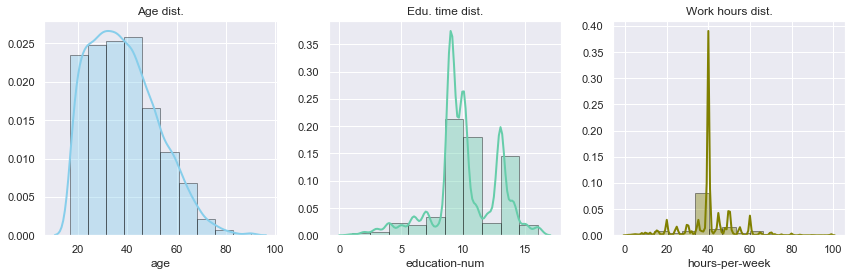

As seen in the plots above, the numerical attributes seem to follow a normal distribution.


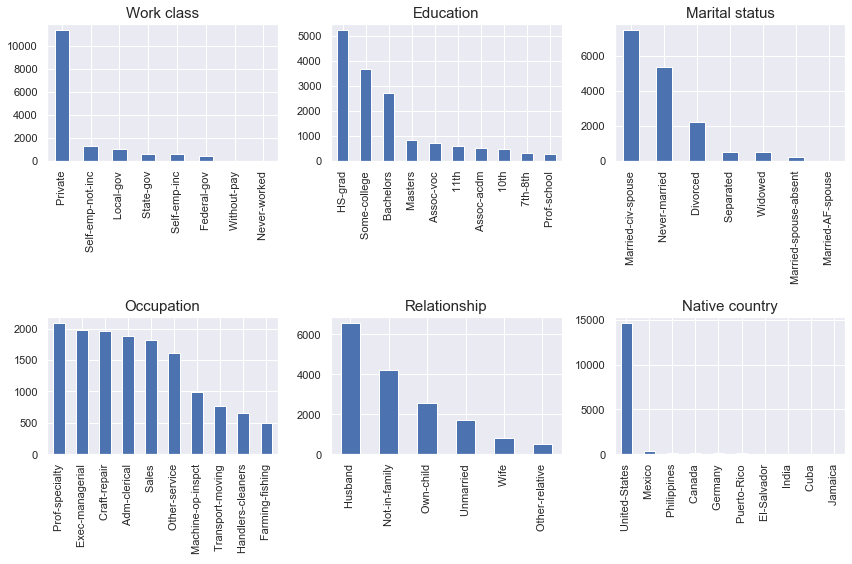

Since there clearly is a separation of classes between the data, most_frequent imputaion tehnique will be used for now.


In [83]:
nan_values = np.where(X_train != X_train)
print(np.unique(nan_values).shape[0], "rows with missing values -> Can't remove 1576 rows since it will affect the training set") 
# Make deep copies
pandas_X_train_copy = copy.deepcopy(pandas_X_train)

# Back-ups
X_train_backup = copy.deepcopy(X_train)
pandas_X_train_backup = copy.deepcopy(pandas_X_train)

# Extended representation of data
extended_pandas = copy.deepcopy(pandas_X_train)
extended_pandas['prediction'] = pandas_y_train

# Plotting numerical
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
sns.distplot(extended_pandas["age"], hist=True, kde=True, 
             bins=10, color = 'skyblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             ax = ax1)

sns.distplot(pandas_X_train_backup["education-num"], hist=True, kde=True, 
             bins=10, color = 'mediumaquamarine', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             ax = ax2)

sns.distplot(pandas_X_train_backup["hours-per-week"], hist=True, kde=True, 
             bins=15, color = 'olive', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             ax = ax3)

ax1.set_title("Age dist.")
ax2.set_title("Edu. time dist.")
ax3.set_title("Work hours dist.")
plt.show()


# Conclusions for numerical attributes
print("As seen in the plots above, the numerical attributes seem to follow a normal distribution.")

# Plotting non-numerical
fig, axarr = plt.subplots(2, 3, figsize=(12, 8), tight_layout=True)
pandas_X_train_backup['workclass'].value_counts().head(10).plot.bar(ax=axarr[0][0])
pandas_X_train_backup['education'].value_counts().head(10).plot.bar(ax=axarr[0][1])
pandas_X_train_backup['marital-status'].value_counts().head(10).plot.bar(ax=axarr[0][2])
pandas_X_train_backup['occupation'].value_counts().head(10).plot.bar(ax=axarr[1][0])
pandas_X_train_backup['relationship'].value_counts().head(10).plot.bar(ax=axarr[1][1])
pandas_X_train_backup['native-country'].value_counts().head(10).plot.bar(ax=axarr[1][2])

axarr[0][0].set_title("Work class", fontsize=15)
axarr[0][1].set_title("Education", fontsize=15)
axarr[0][2].set_title("Marital status", fontsize=15)
axarr[1][0].set_title("Occupation", fontsize=15)
axarr[1][1].set_title("Relationship", fontsize=15)
axarr[1][2].set_title("Native country", fontsize=15)
plt.show()


print("Since there clearly is a separation of classes between the data, most_frequent imputaion tehnique will be used for now.")

# Replace missing numerical values with the median of the column
# Replace missing string values with the most frequent value in the column
pandas_X_train_copy.fillna(pandas_X_train_copy.mean(), inplace=True)
pandas_X_train_copy.fillna(pandas_X_train_copy.mode(numeric_only=False).iloc[0], inplace=True)

pandas_X_train_copy.drop(["race", "sex"], inplace=True, axis=1) # Remove race & sex from the training dataset
X_train = pandas_X_train_copy.to_numpy(copy=True)

# Update values of pandas_X_train and X_train
pandas_X_train = copy.deepcopy(pandas_X_train_copy)
X_train = pandas_X_train_copy.to_numpy(copy=True)

### Question 2

In [86]:
# Additional preprocessing needs to be done: every non-numerical column has a space before the value <_space_*value*>
# pandas:
pandas_X_train.workclass = pandas_X_train.workclass.str.strip()
pandas_X_train.education = pandas_X_train.education.str.strip()
pandas_X_train["marital-status"] = pandas_X_train["marital-status"].str.strip()
pandas_X_train.occupation = pandas_X_train.occupation.str.strip()
pandas_X_train.relationship = pandas_X_train.relationship.str.strip()
pandas_X_train["native-country"] = pandas_X_train["native-country"].str.strip()

# removing categories:
# this process decreases the computational costs and prevents for potential overfitting
pandas_X_train['native-country'].replace(list(pandas_X_train['native-country'].value_counts().index)[20:], "others", inplace=True)
X_train = pandas_X_train.to_numpy(copy=True)

# classes:
workclass = pandas_X_train.workclass.unique()
education = pandas_X_train.education.unique()
marital_status = pandas_X_train["marital-status"].unique()
occupation = pandas_X_train.occupation.unique()
relationship = pandas_X_train.relationship.unique()
native_country = pandas_X_train["native-country"].unique()

# Using OneHotEncoder: for all attributes except the first 3
encoder = preprocessing.OneHotEncoder(categories=[workclass, education, marital_status, occupation, relationship, native_country], sparse=False)
X_train_categorically_encoded = encoder.fit_transform(X_train[:, 3:])
X_train_encoded = np.c_[X_train[:, :3], X_train_categorically_encoded]

# Using get dummies
pandas_X_train_encoded = pd.get_dummies(pandas_X_train, prefix_sep='_', drop_first=True)
pandas_X_train_encoded_backup = copy.deepcopy(pandas_X_train_encoded)

# Normalization: first 3 attributes: age, education-num, hours-per-week
X_train_cat_normalized = preprocessing.normalize(pandas_X_train_encoded[["age", "education-num", "hours-per-week"]], norm="l1")
X_train_normalized = np.c_[X_train_cat_normalized, X_train_encoded[:, 3:]]

### Question 3

## Experiments

### Question 1

In [87]:
X_data_norm = copy.deepcopy(X_train_normalized)
X_data_enc = copy.deepcopy(X_train_encoded)
y_data = copy.deepcopy(y_train)


# using train_test_split
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_data_norm, y_data, test_size=0.25, random_state=42, shuffle=True, stratify=np.ravel(y_data))
y_train_new = y_train_new.reshape(len(y_train_new),)
y_test_new = y_test_new.reshape(len(y_test_new),)

# using kfold
def k_fold_fit_evaluate(X, y, model, scoring_method, n_splits=2):
    k_fold = KFold(n_splits=n_splits, random_state=42, shuffle=True)
    scores = cross_validate(model, X, y, scoring=scoring_method, cv=k_fold, n_jobs=-1)
    return scores["test_score"]

# using stratified kfold
def sk_fold_fit_evaluate(X, y, model, scoring_method, n_splits=2):
    sk_fold = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)
    scores = cross_validate(model, X, y, scoring=scoring_method, cv=sk_fold, n_jobs=-1)
    return scores["test_score"]

### Question 2

Number of splits for the K Folds: 10


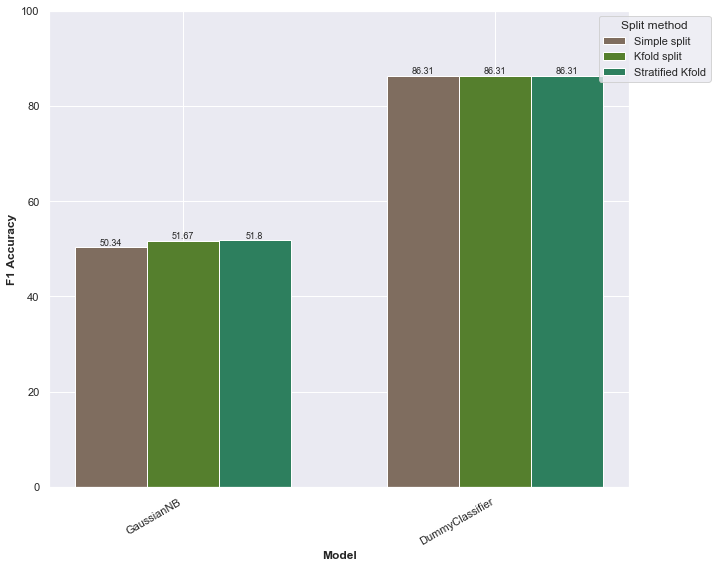

In [88]:
random_state = 42

models = {
    "GaussianNB": GaussianNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier(max_depth=None, min_samples_leaf=2, random_state=random_state),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=3, weights="distance"),
    "SVM": SVC(C=10, kernel ="poly", random_state=random_state),
    "LogisticRegression": LogisticRegression(C=10, penalty="none", random_state=42)  
}

# The evaluation method
scoring_method_f1 = make_scorer(lambda prediction, true_target: f1_score(true_target, prediction, average="weighted"))

n_splits = 10
dict_simple = dict()
dict_kfold = dict()
dict_skfold = dict()

for name, model in models.items():
    # simple model fitting
    model.fit(X_train_new, y_train_new)
    prediction = model.predict(X_test_new)
    simple_metrics_f1 = f1_score(prediction, y_test_new, average="weighted")
    
    # kfold
    kf_metrics_f1 = k_fold_fit_evaluate(X_data_norm, np.ravel(y_data), model, scoring_method_f1, n_splits=n_splits) 

    # stratified kfold
    skf_metrics_f1 = sk_fold_fit_evaluate(X_data_norm, np.ravel(y_data), model, scoring_method_f1, n_splits=n_splits) 

    # gather performance data
    dict_simple[name] = np.round(np.mean(simple_metrics_f1)*100, 2)
    dict_kfold[name] = np.round(np.mean(kf_metrics_f1)*100, 2)
    dict_skfold[name] = np.round(np.mean(skf_metrics_f1)*100, 2)
    
    
print("Number of splits for the K Folds:", n_splits)
    
barWidth = 0.23
bars1 = list(dict_simple.values())
bars2 = list(dict_kfold.values())
bars3 = list(dict_skfold.values())

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

fig = plt.figure(figsize=(10, 8))
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Simple split')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='Kfold split')
plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='Stratified Kfold')

plt.xticks([r + barWidth for r in range(len(bars1))], list(models.keys()))
plt.xlabel('Model', fontweight='bold')
plt.ylabel('F1 Accuracy', fontweight='bold')

for i in range(len(bars1)):
    plt.annotate(str(bars1[i]), xy=(r1[i],bars1[i]), ha='center', va='bottom', size=9)
    plt.annotate(str(bars2[i]), xy=(r2[i],bars2[i]), ha='center', va='bottom', size=9)
    plt.annotate(str(bars3[i]), xy=(r3[i],bars3[i]), ha='center', va='bottom', size=9)

plt.legend(bbox_to_anchor=(1.15, 1), loc='upper right', title='Split method')
fig.autofmt_xdate()
plt.tight_layout()
plt.ylim(0, 100)    
plt.show()

### Experiments

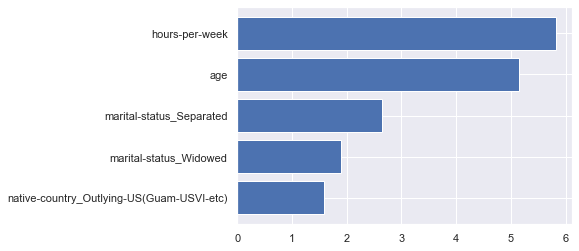

F1 accuracy of logistic regression: 83.93


In [227]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression

# can be deleted

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names[70:])), imp[70:], align='center')
    plt.yticks(range(len(names[70:])), names[70:])
    plt.show()

# features_names = list(pandas_X_train_encoded.columns)
# svm = SVC(kernel='linear', random_state=42, C=7)
# svm.fit(X_train_new, y_train_new)
# f_importances(svm.coef_.ravel()[:88], features_names)

# svm_kf_metrics_f1 = k_fold_fit_evaluate(X_data_norm, np.ravel(y_data), svm, scoring_method_f1, n_splits=n_splits) 
# print("F1 accuracy of SVM:",np.round(np.mean(svm_kf_metrics_f1)*100, 2))

features_names = list(pandas_X_train_encoded.columns)
logistic = LogisticRegression(C=4, random_state=42, max_iter=1000)
logistic.fit(X_train_new, y_train_new)
f_importances(logistic.coef_.ravel()[:88], features_names)

log_kf_metrics_f1 = k_fold_fit_evaluate(X_data_norm, np.ravel(y_data), logistic, scoring_method_f1, n_splits=n_splits) 
print("F1 accuracy of logistic regression:",np.round(np.mean(log_kf_metrics_f1)*100, 2))

### Question 3

F1 accuracy of model, done with kfold, after hyper-parameter tuning with the current given parameters.
GaussianNB
- best_score = 0.44409069329500844
- best parameters:
DecisionTreeClassifier
- best_score = 0.838338622421135
- best parameters:
  - max_depth 5
  - min_samples_leaf 5
  - random_state 42
KNeighborsClassifier
- best_score = 0.8328754443653013
- best parameters:
  - n_neighbors 10
  - weights uniform
SVM
- best_score = 0.8388804764701616
- best parameters:
  - C 10
  - kernel linear
  - random_state 42
LogisticRegression
- best_score = 0.8406007940760553
- best parameters:
  - C 4
  - max_iter 1000
  - penalty l2
  - random_state 42


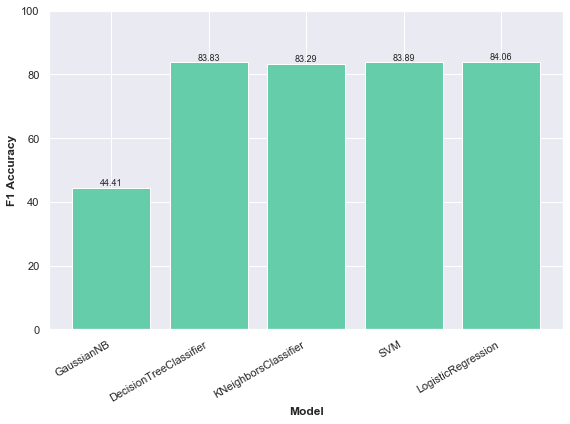

In [52]:
# Getting the model parameters
model_parameters = {
    "GaussianNB": {},
    "DecisionTreeClassifier": {
        'max_depth': [None, 5, 10],
        'random_state': [random_state],
        'min_samples_leaf': [4, 5, 7]
    },
    "KNeighborsClassifier": {
        'n_neighbors': [7, 10, 13],
        'weights': ['uniform', 'distance']
    },
    "SVM": {
        'C': [2, 4],
        'kernel': ['rbf', 'linear', 'poly'],
        'random_state': [random_state]
    },
    "LogisticRegression": {
        'C': [2, 4, 7],
        'penalty': ['none', 'l1', 'l2'],
        'random_state': [random_state],
        'max_iter': [1000]
    }
}

dict_models = dict()
print("F1 accuracy of model, done with kfold, after hyper-parameter tuning with the current given parameters.")

for model_name, parameters in model_parameters.items():
    model = models[model_name]
    
    # cv = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    cv = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=-1, verbose=False, scoring=scoring_method_f1).fit(X_data_norm, np.ravel(y_data))

    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_
    
    dict_models[model_name] = np.round(np.mean(best_score)*100, 2)
    
    print(model_name)
    print("- best_score =", best_score)
    print("- best parameters:")
    for k,v in best_params.items():
        print("  -", k, v)

bar = list(dict_models.values())
r = np.arange(len(bar))

fig = plt.figure(figsize=(8, 6))
plt.bar(*zip(*dict_models.items()), color='mediumaquamarine')
plt.xlabel('Model', fontweight='bold')
plt.ylabel('F1 Accuracy', fontweight='bold')

for i in range(len(bar)):
    plt.annotate(str(bar[i]), xy=(r[i],bar[i]), ha='center', va='bottom', size=9)

fig.autofmt_xdate()
plt.tight_layout()
plt.ylim(0, 100)
plt.show()

### Question 4

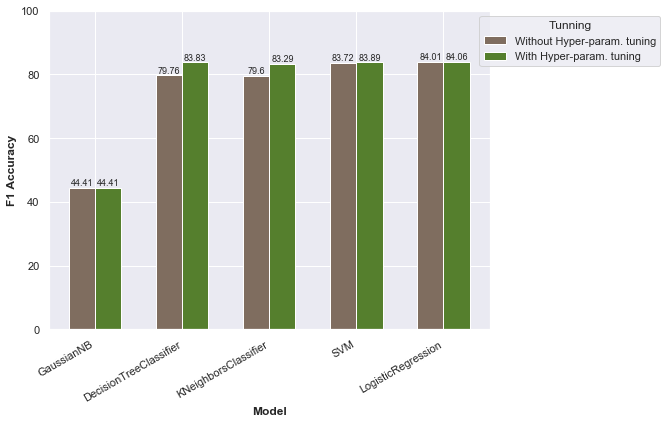

In [56]:
barWidth = 0.30
bars1 = list(dict_kfold.values())
bars2 = list(dict_models.values())

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

fig = plt.figure(figsize=(10, 6))
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Without Hyper-param. tuning')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='With Hyper-param. tuning')

plt.xticks([r + barWidth/2 for r in range(len(bars1))],list(model_parameters.keys()))
plt.xlabel('Model', fontweight='bold')
plt.ylabel('F1 Accuracy', fontweight='bold')


for i in range(len(bars1)):
    plt.annotate(str(bars1[i]), xy=(r1[i],bars1[i]), ha='center', va='bottom', size=9)
    plt.annotate(str(bars2[i]), xy=(r2[i],bars2[i]), ha='center', va='bottom', size=9)

plt.legend(bbox_to_anchor=(1.4, 1), loc='upper right', title='Tunning')
fig.autofmt_xdate()
plt.tight_layout()
plt.ylim(0, 100)    
plt.show()

### Question 5

In [54]:
prediction = np.array([-1] * len(X_test)) #TODO replace this with you own prediction
pd.DataFrame(prediction).to_csv("GROUP_classes_problem_census.txt", index=False, header=False)

### Helpers

In [55]:
# barWidth = 0.23
# bars1 = np.random.randint(75,80,5)
# bars2 = np.random.randint(75,80,5)
# bars3 = np.random.randint(75,80,5)

# # Set position of bar on X axis
# r1 = np.arange(len(bars1))
# r2 = [x + barWidth for x in r1]
# r3 = [x + barWidth for x in r2]

# fig = plt.figure(figsize=(10, 6))
# plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='simple')
# plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='kfold')
# plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='skfold')

# plt.xticks([r + barWidth for r in range(len(bars1))],list(models.keys()))
# plt.xlabel('Model', fontweight='bold')
# plt.ylabel('F1 Accuracy', fontweight='bold')


# for i in range(len(bars1)):
#     plt.annotate(str(bars1[i]) + ".26", xy=(r1[i],bars1[i]), ha='center', va='bottom', size=8)
#     plt.annotate(str(bars2[i]) + ".87", xy=(r2[i],bars2[i]), ha='center', va='bottom', size=8)
#     plt.annotate(str(bars3[i]) + ".92", xy=(r3[i],bars3[i]), ha='center', va='bottom', size=8)

# plt.legend(bbox_to_anchor=(1.15, 1), loc='upper right', title='Split method')
# fig.autofmt_xdate()
# plt.tight_layout()
# plt.ylim(0, 100)    
# plt.show()

#############################################

# temp = {'Luca': 88.2, 'Andrei': 83.57, 'Apollo': 88.32, 'Gauss': 87.59, 'Pareto': 80.20}
# bar = list(temp.values())
# r = np.arange(len(bar))
# fig = plt.figure(figsize=(8, 6))
# plt.bar(*zip(*temp.items()), color='mediumaquamarine')

# for i in range(len(temp.values())):
#     plt.annotate(str(bar[i]), xy=(r[i],bar[i]), ha='center', va='bottom', size=8)

# fig.autofmt_xdate()
# plt.tight_layout()
# plt.ylim(0, 100)
# plt.show()